In [1]:
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import xgboost as xgb

In [2]:
TRAINING_DIR = "/Users/quanghuypham/Desktop/SC numpy 20k bee dataset/train"
VALIDATION_DIR = "/Users/quanghuypham/Desktop/SC numpy 20k bee dataset/val"
TEST_DIR = "/Users/quanghuypham/Desktop/SC numpy 20k bee dataset/test"

def load_data(directory):
    sc_features = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if not os.path.isdir(label_dir):
            continue
        for filename in os.listdir(label_dir):
            file_path = os.path.join(label_dir, filename)
            if not os.path.isfile(file_path):
                continue
            sc = np.load(file_path)
            sc_features.append(sc)
            labels.append(label)
    return sc_features, labels

train_sc_features, train_labels = load_data(TRAINING_DIR)
val_sc_features, val_labels = load_data(VALIDATION_DIR)
test_sc_features, test_labels = load_data(TEST_DIR)

In [3]:
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.transform(val_labels)
encoded_test_labels = label_encoder.transform(test_labels)

In [4]:
X_train = np.array(train_sc_features)
y_train = np.array(encoded_train_labels)

X_val = np.array(val_sc_features)
y_val = np.array(encoded_val_labels)

X_test = np.array(test_sc_features)
y_test = np.array(encoded_test_labels)

In [5]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

In [6]:
def get_stacking():
    level0 = list()
    level0.append(('rf', RandomForestClassifier(random_state=1337)))
    level0.append(('et', ExtraTreesClassifier(random_state=1337)))
    level0.append(('xgb', xgb.XGBClassifier(random_state=1337)))
    level1 = RandomForestClassifier(random_state=1337)
    
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [7]:
import time

t1=time.time()

model = get_stacking()
score = evaluate_model(model, X_train_normalized, y_train)
t2=time.time()
print(t2-t1,'s')
print(score)

170.8933560848236 s
[0.78785714 0.81785714 0.77785714 0.8        0.79142857 0.79714286
 0.81071429 0.78857143 0.78642857 0.79285714 0.80214286 0.80214286
 0.79571429 0.80428571 0.78928571 0.77142857 0.79142857 0.80642857
 0.77642857 0.79214286 0.78357143 0.78571429 0.79642857 0.78928571
 0.79928571 0.805      0.805      0.79142857 0.79642857 0.805     ]


In [11]:
from numpy import mean
from numpy import std

print(mean(score), std(score))

0.7946428571428571 0.010214951693240555


In [8]:
model = get_stacking()

t3=time.time()
model.fit(X_train_normalized, y_train)
t4=time.time()
print(t4-t3,'s')

y_pred = model.predict(X_test_normalized)
accuracy = model.score(X_test_normalized, y_test)
print("Test Accuracy:", accuracy)

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

19.828389883041382 s
Test Accuracy: 0.81
Classification Report:
               precision    recall  f1-score   support

       Queen       0.80      0.82      0.81      2000
   Queenless       0.82      0.80      0.81      2000

    accuracy                           0.81      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.81      0.81      0.81      4000



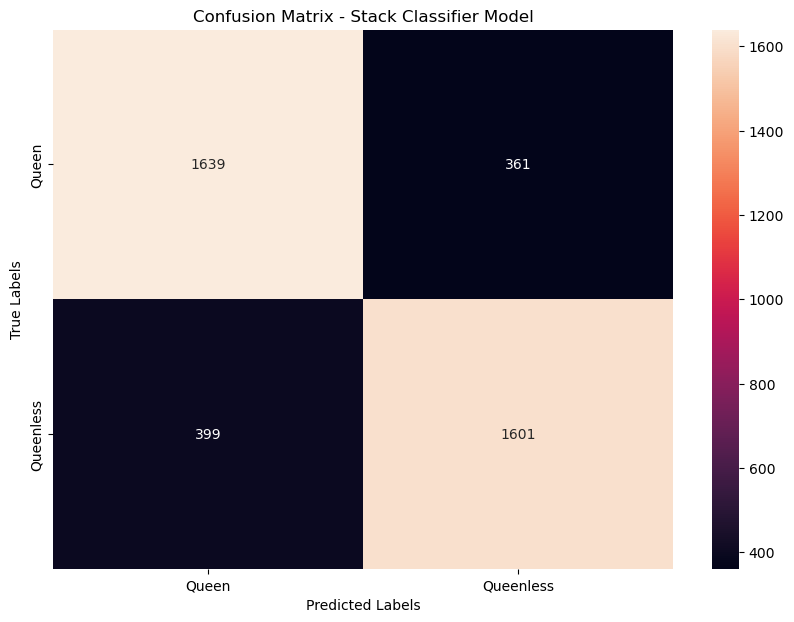

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_labels = label_encoder.classes_
confusion_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt="", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Stack Classifier Model')
plt.show()


In [15]:
import pickle

with open('sc_stack.pkl', 'wb') as f:
    pickle.dump(model, f)